In [4]:
#####Remove the comment and install the following libraries
#!pip install pytorch-forecastingimport numpy as np
import pandas as pd
import torch
import torch.nn as nn

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, MAE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [5]:
data= pd.read_excel("/kaggle/input/airqualityuci/AirQualityUCI.xlsx")

In [7]:
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [8]:
x=data.isnull().sum()
x

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

## Continuos Feature Report

In [9]:
numeric_features= data.select_dtypes(include=[np.number])
def build_continuous_features_report(data_df):
    
    """Build tabular report for continuous features"""

    stats = {
        "Count": len,
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,
        "Card.": lambda df: df.nunique(),
        "Min": lambda df: df.min(),
        "1st Qrt.": lambda df: df.quantile(0.25),
        "Mean": lambda df: df.mean(),
        "Median": lambda df: df.median(),
        "3rd Qrt": lambda df: df.quantile(0.75),
        "Max": lambda df: df.max(),
        "Std. Dev.": lambda df: df.std(),
    }

    contin_feat_names = data_df.select_dtypes("number").columns
    continuous_data_df = data_df[contin_feat_names]

    report_df = pd.DataFrame(index=contin_feat_names, columns=stats.keys())

    for stat_name, fn in stats.items():
        # NOTE: ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(continuous_data_df)

    return report_df

build_continuous_features_report(data)

,Count,Miss %,Card.,Min,1st Qrt.,Mean,Median,3rd Qrt,Max,Std. Dev.
CO(GT),9357,0.0,97,-200.0,0.600000,-34.207524,1.500000,2.600000,11.900000,77.657170
PT08.S1(CO),9357,0.0,3246,-200.0,921.000000,1048.869652,1052.500000,1221.250000,2039.750000,329.817015
NMHC(GT),9357,0.0,430,-200.0,-200.000000,-159.090093,-200.000000,-200.000000,1189.000000,139.789093
C6H6(GT),9357,0.0,3773,-200.0,4.004958,1.865576,7.886653,13.636091,63.741476,41.380154
PT08.S2(NMHC),9357,0.0,3773,-200.0,711.000000,894.475963,894.500000,1104.750000,2214.000000,342.315902
NOx(GT),9357,0.0,2467,-200.0,50.000000,168.604200,141.000000,284.200000,1479.000000,257.424561
PT08.S3(NOx),9357,0.0,3519,-200.0,637.000000,794.872333,794.250000,960.250000,2682.750000,321.977031
NO2(GT),9357,0.0,1420,-200.0,53.000000,58.135898,96.000000,133.000000,339.700000,126.931428
PT08.S4(NO2),9357,0.0,4408,-200.0,1184.750000,1391.363266,1445.500000,1662.000000,2775.000000,467.192382
PT08.S5(O3),9357,0.0,4679,-200.0,699.750000,974.951534,942.000000,1255.250000,2522.750000,456.922728


# Exploratory Data Analysis(EDA)

In [10]:
import pandas as pd

# Define the data for the table
df = {
    'Variable Name': ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)'],
    'Role': ['Feature', 'Feature', 'Feature', 'Feature', 'Feature', 'Feature', 'Feature', 'Feature', 'Feature', 'Feature'],
    'Type': ['Date', 'Categorical', 'Integer', 'Categorical', 'Integer', 'Continuous', 'Categorical', 'Integer', 'Categorical', 'Integer'],
    'Description': [
        'Date of the measurement',
        'Time of the measurement',
        'True hourly averaged concentration of CO in mg/m³ (reference analyzer)',
        'Hourly averaged sensor response (nominal CO targeted)',
        'True hourly averaged overall Non-Methanic HydroCarbons concentration in microg/m³ (reference analyzer)',
        'True hourly averaged Benzene concentration in microg/m³ (reference analyzer)',
        'Hourly averaged sensor response (nominal NMHC targeted)',
        'True hourly averaged NOx concentration in ppb (reference analyzer)',
        'Hourly averaged sensor response (nominal NOx targeted)',
        'True hourly averaged NO2 concentration in microg/m³ (reference analyzer)'
    ],
    'Units': ['N/A', 'N/A', 'mg/m³', 'N/A', 'microg/m³', 'microg/m³', 'N/A', 'ppb', 'N/A', 'microg/m³']
}


df_description = pd.DataFrame(df)


print(df_description)


   Variable Name     Role         Type  \
0           Date  Feature         Date   
1           Time  Feature  Categorical   
2         CO(GT)  Feature      Integer   
3    PT08.S1(CO)  Feature  Categorical   
4       NMHC(GT)  Feature      Integer   
5       C6H6(GT)  Feature   Continuous   
6  PT08.S2(NMHC)  Feature  Categorical   
7        NOx(GT)  Feature      Integer   
8   PT08.S3(NOx)  Feature  Categorical   
9        NO2(GT)  Feature      Integer   

                                         Description      Units  
0                            Date of the measurement        N/A  
1                            Time of the measurement        N/A  
2  True hourly averaged concentration of CO in mg...      mg/m³  
3  Hourly averaged sensor response (nominal CO ta...        N/A  
4  True hourly averaged overall Non-Methanic Hydr...  microg/m³  
5  True hourly averaged Benzene concentration in ...  microg/m³  
6  Hourly averaged sensor response (nominal NMHC ...        N/A  
7  True h

In [11]:
data['datetime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time'].astype(str))

#data.set_index('datetime',inplace=True)
data.drop(['Date','Time'],axis = 1,inplace = True)

In [12]:
data.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,datetime
0,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754,2004-03-10 18:00:00
1,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487,2004-03-10 19:00:00
2,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239,2004-03-10 20:00:00
3,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713,2004-03-10 21:00:00
4,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794,2004-03-10 22:00:00


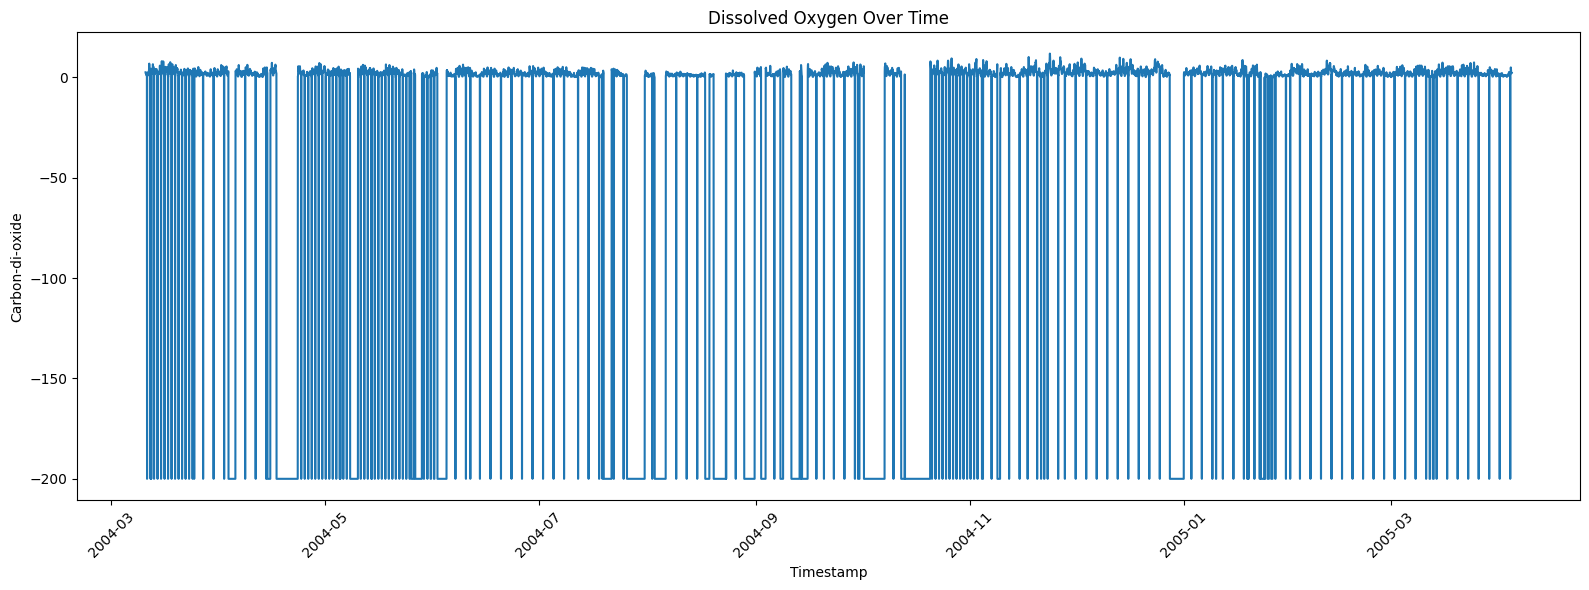

In [13]:
plt.figure(figsize=(16, 6))  # Adjust the size as needed  linestyle='-', color='blue'
plt.plot(data['datetime'], data['CO(GT)'] )
plt.title('Dissolved Oxygen Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Carbon-di-oxide')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [14]:
count_negative_200 = len(data[data['CO(GT)'] == -200])
count_negative_200

1683

From the above plot we can see that th

In [15]:
total_counts = numeric_features.count()
negative_value_counts = (numeric_features < 0).sum()

percentage_negative = (negative_value_counts / total_counts) * 100

results_df = pd.DataFrame({
    'Total_Count': total_counts,
    'Negative_Count': negative_value_counts,
    'Percentage_Negative': percentage_negative
})

print("Number of negative values in each numeric column:")
print(results_df)

Number of negative values in each numeric column:
               Total_Count  Negative_Count  Percentage_Negative
CO(GT)                9357            1683            17.986534
PT08.S1(CO)           9357             366             3.911510
NMHC(GT)              9357            8443            90.231912
C6H6(GT)              9357             366             3.911510
PT08.S2(NMHC)         9357             366             3.911510
NOx(GT)               9357            1639            17.516298
PT08.S3(NOx)          9357             366             3.911510
NO2(GT)               9357            1642            17.548360
PT08.S4(NO2)          9357             366             3.911510
PT08.S5(O3)           9357             366             3.911510
T                     9357             380             4.061131
RH                    9357             366             3.911510
AH                    9357             366             3.911510


In [16]:
negative_values = data[data['CO(GT)'] < 0]
print('The precentage of CO2 having negative value',len(negative_values)/len(data['CO(GT)'])*100)

The precentage of CO2 having negative value 17.986534145559474


In [17]:
total_counts = numeric_features.count()
negative_value_counts = (numeric_features < 0).sum()

percentage_negative = (negative_value_counts / total_counts) * 100

results_df = pd.DataFrame({
    'Total_Count': total_counts,
    'Negative_Count': negative_value_counts,
    'Percentage_Negative': percentage_negative
})

print("Number of negative values in each numeric column:")
print(results_df)

Number of negative values in each numeric column:
               Total_Count  Negative_Count  Percentage_Negative
CO(GT)                9357            1683            17.986534
PT08.S1(CO)           9357             366             3.911510
NMHC(GT)              9357            8443            90.231912
C6H6(GT)              9357             366             3.911510
PT08.S2(NMHC)         9357             366             3.911510
NOx(GT)               9357            1639            17.516298
PT08.S3(NOx)          9357             366             3.911510
NO2(GT)               9357            1642            17.548360
PT08.S4(NO2)          9357             366             3.911510
PT08.S5(O3)           9357             366             3.911510
T                     9357             380             4.061131
RH                    9357             366             3.911510
AH                    9357             366             3.911510


## Data Prepartion and Feature Engineering

In [18]:
# Dropped NMHC(GT) because it has 90.231912% negative values. Parti
data.drop(['NMHC(GT)'],axis = 1,inplace = True)
numeric_features = data.select_dtypes(include=[np.number])

# Replacing the nagtive values with Nan
numeric_features = numeric_features.mask(numeric_features < 0)

# Impute NaN values with median
numeric_features = numeric_features.fillna(numeric_features.median())

# Update 'data' DataFrame with imputed values
data[numeric_features.columns] = numeric_features


In [19]:

total_counts = numeric_features.count()
negative_value_counts = (numeric_features < 0).sum()


percentage_negative = (negative_value_counts / total_counts) * 100


results_df = pd.DataFrame({
    'Total_Count': total_counts,
    'Negative_Count': negative_value_counts,
    'Percentage_Negative': percentage_negative
})

print("Number of negative values in each numeric column after processing:")
print(results_df)

Number of negative values in each numeric column after processing:
               Total_Count  Negative_Count  Percentage_Negative
CO(GT)                9357               0                  0.0
PT08.S1(CO)           9357               0                  0.0
C6H6(GT)              9357               0                  0.0
PT08.S2(NMHC)         9357               0                  0.0
NOx(GT)               9357               0                  0.0
PT08.S3(NOx)          9357               0                  0.0
NO2(GT)               9357               0                  0.0
PT08.S4(NO2)          9357               0                  0.0
PT08.S5(O3)           9357               0                  0.0
T                     9357               0                  0.0
RH                    9357               0                  0.0
AH                    9357               0                  0.0


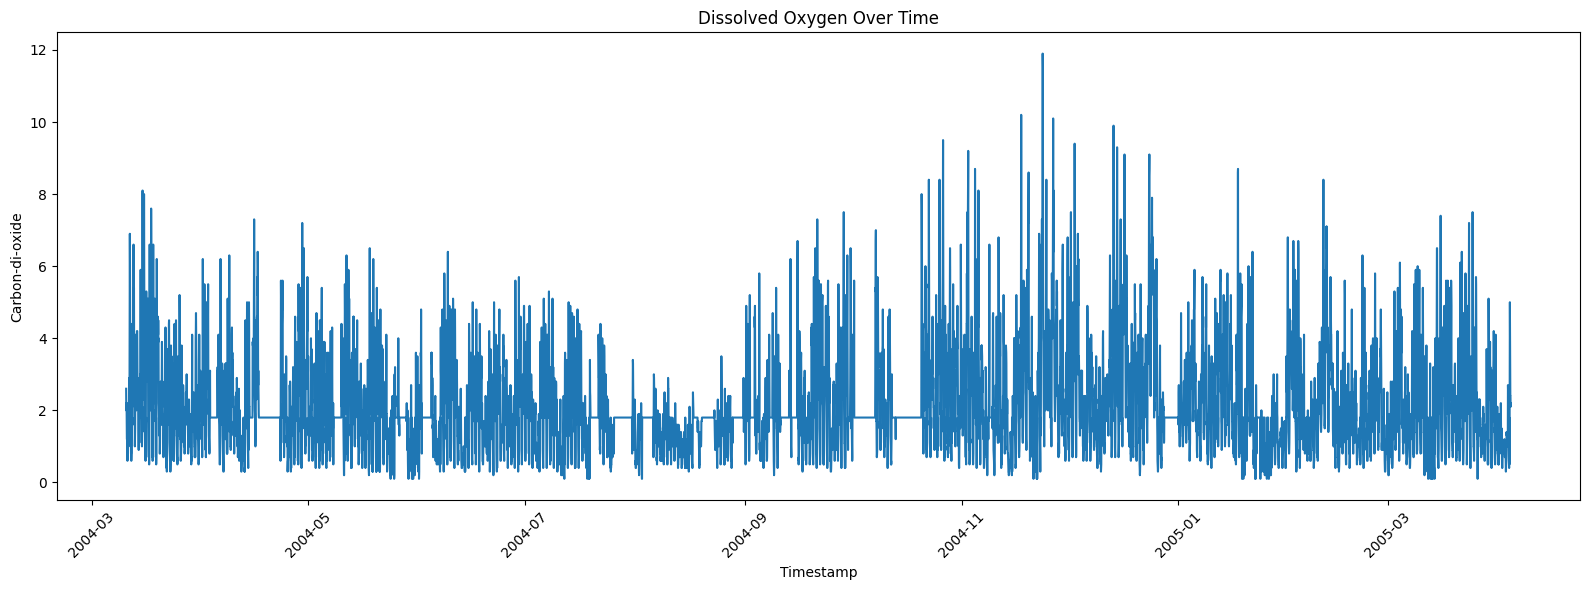

In [20]:
plt.figure(figsize=(16, 6))  
plt.plot(data['datetime'], data['CO(GT)'] )
plt.title('Dissolved Oxygen Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Carbon-di-oxide')
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

In [ ]:
data.isnull().sum()

In [21]:
data.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,datetime
0,2.6,1360.00,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754,2004-03-10 18:00:00
1,2.0,1292.25,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487,2004-03-10 19:00:00
2,2.2,1402.00,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239,2004-03-10 20:00:00
3,2.2,1375.50,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713,2004-03-10 21:00:00
4,1.6,1272.25,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794,2004-03-10 22:00:00


Since the objective is calulating 24- hour future value therefore, we wiil shift the our target varaibles by future 24 values so that the model learns to predict future values.The temporal order will reamin the same also other feautures will also remain the same as  it will the model to learn how the current features relate to the future target values.

In [22]:
## Shifitng the target feature to 24 rows ahead 
data['CO(GT)'] = data['CO(GT)'].shift(-24)


In [23]:
## The missing value for shifitng the rows are imputed by median
data['CO(GT)'] = data['CO(GT)'].fillna(data['CO(GT)'].median())

In [24]:
data['datetime'] = pd.to_datetime(data['datetime'])

# Creating 'day', 'month', and 'hour' features from the datetime column
data['day'] = data['datetime'].dt.day.astype(str)
data['month'] = data['datetime'].dt.month.astype(str)
data['hour'] = data['datetime'].dt.hour.astype(str)
data['time_idx'] = range(len(data))

In [25]:
data.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,datetime,day,month,hour,time_idx
0,4.8,1360.00,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754,2004-03-10 18:00:00,10,3,18,0
1,6.9,1292.25,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487,2004-03-10 19:00:00,10,3,19,1
2,6.1,1402.00,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239,2004-03-10 20:00:00,10,3,20,2
3,3.9,1375.50,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713,2004-03-10 21:00:00,10,3,21,3
4,1.5,1272.25,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794,2004-03-10 22:00:00,10,3,22,4


## Modelling

### Splititng the dataset

In [26]:
data.columns = [col.replace('.', '_') for col in data.columns]
total_rows = len(data)

# Spliting 70% for training and the remaining 30% for testing
train_end = int(total_rows * 0.7)
train_data = data.iloc[:train_end]
test_data = data.iloc[train_end:]

# Now,again 80% of the training data for actual training and 20% for validation

validation_cutoff = int(len(train_data) * 0.8)

# Spliting the training data into training and validation sets
train_actual = train_data.iloc[:validation_cutoff]
validation_data = train_data.iloc[validation_cutoff:]
print("Training Data Shape:", train_actual.shape)
print("Validation Data Shape:", validation_data.shape)
print("Testing Data Shape:", test_data.shape)



Training Data Shape: (5239, 17)
Validation Data Shape: (1310, 17)
Testing Data Shape: (2808, 17)


In [27]:
data.head()

,CO(GT),PT08_S1(CO),C6H6(GT),PT08_S2(NMHC),NOx(GT),PT08_S3(NOx),NO2(GT),PT08_S4(NO2),PT08_S5(O3),T,RH,AH,datetime,day,month,hour,time_idx
0,4.8,1360.00,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754,2004-03-10 18:00:00,10,3,18,0
1,6.9,1292.25,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487,2004-03-10 19:00:00,10,3,19,1
2,6.1,1402.00,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239,2004-03-10 20:00:00,10,3,20,2
3,3.9,1375.50,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713,2004-03-10 21:00:00,10,3,21,3
4,1.5,1272.25,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794,2004-03-10 22:00:00,10,3,22,4


In [29]:
max_prediction_length = 24
max_encoder_length = 24

train_actual['group'] = 0

training = TimeSeriesDataSet(
    train_actual,
    time_idx="time_idx",
    target="CO(GT)",  
    group_ids=["group"],  # Single time series
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],  # No static categoricals in the dataset
    static_reals=[],  # No static reals the dataset
    time_varying_known_categoricals=["day", "month", "hour"],  # Time-related features
    time_varying_known_reals=["time_idx"],  # Known reals including time index
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        'PT08_S1(CO)', 'C6H6(GT)', 'PT08_S2(NMHC)', 'NOx(GT)',
       'PT08_S3(NOx)', 'NO2(GT)', 'PT08_S4(NO2)', 'PT08_S5(O3)', 'T', 'RH', 'AH'
    ], 
    target_normalizer=GroupNormalizer(groups=["group"], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,    
    categorical_encoders={
        "day": NaNLabelEncoder(add_nan=True),
        "month": NaNLabelEncoder(add_nan=True),
        "hour": NaNLabelEncoder(add_nan=True)
    }
)

In [30]:
# Dataloaders for model
batch_size = 64  
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers= 0 )
validation_data['group'] = 0
validation = TimeSeriesDataSet.from_dataset(training, validation_data, predict=True, stop_randomization=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers= 0)


## Baseline Model

In [31]:
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
2024-08-22 14:53:15.088430: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 14:53:15.088498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 14:53:15.090211: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory 

tensor(0.9250, device='cuda:0')

## Opimal Learning Rate

In [32]:
pl.seed_everything(42)

# GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"


trainer = pl.Trainer(
    accelerator=device,
    gradient_clip_val=0.1,
)

# TemporalFusionTransformer model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,  # This can be adjusted later with the found optimal learning rate
    hidden_size=8,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    optimizer="Ranger",
)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO: Seed set to 42
INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


Number of parameters in network: 12.2k


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO: Learning rate set to 0.17782794100389226
INFO: Restoring states from the checkpoint path at /kaggle/working/.lr_find_19ee2ec8-24e2-4a15-ba6b-f2e5cf7cc080.ckpt
INFO: Restored all states from the checkpoint at /kaggle/working/.lr_find_19ee2ec8-24e2-4a15-ba6b-f2e5cf7cc080.ckpt


suggested learning rate: 0.17782794100389226


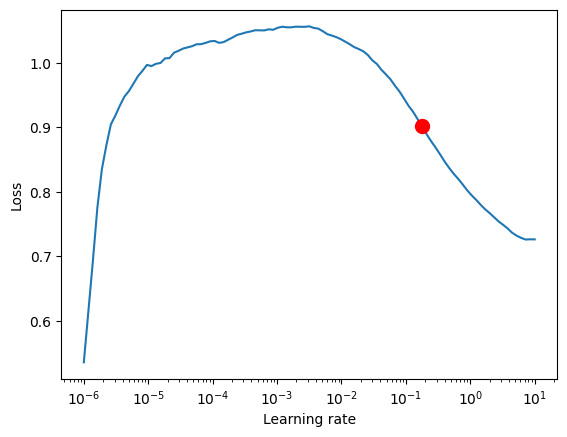

In [33]:
#from lightning.pytorch.tuner import Tuner
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig =  res.plot(show=True, suggest=True)
fig.show()

In [34]:

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator=device,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  
    # fast_dev_run=True,  
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.2,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


Number of parameters in network: 28.2k


In [35]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 647    | train
3  | prescalers                         | ModuleDict                      | 256    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 10.3 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.6 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Hyperparameter Tuning

In [ ]:
# import optuna
# #from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
# # study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=200,
#     max_epochs=50,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )


# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# print(study.best_trial.params)

In [36]:
import pickle
import random


# Hyperparameter tuning using random search
def random_search_tuning(num_trials, hyperparameter_ranges):
    best_params = None
    best_loss = float("inf")
    
    for _ in range(num_trials):
        
        params = {
            "hidden_size": random.randint(hyperparameter_ranges["hidden_size"][0], hyperparameter_ranges["hidden_size"][1]),
            "hidden_continuous_size": random.randint(hyperparameter_ranges["hidden_continuous_size"][0], hyperparameter_ranges["hidden_continuous_size"][1]),
            "attention_head_size": random.randint(hyperparameter_ranges["attention_head_size"][0], hyperparameter_ranges["attention_head_size"][1]),
            "learning_rate": random.uniform(hyperparameter_ranges["learning_rate"][0], hyperparameter_ranges["learning_rate"][1]),
            "dropout": random.uniform(hyperparameter_ranges["dropout"][0], hyperparameter_ranges["dropout"][1]),
            "gradient_clip_val": random.uniform(hyperparameter_ranges["gradient_clip_val"][0], hyperparameter_ranges["gradient_clip_val"][1]),
        }
        
        
        tft = TemporalFusionTransformer.from_dataset(
            training,
            hidden_size=params["hidden_size"],
            attention_head_size=params["attention_head_size"],
            dropout=params["dropout"],
            hidden_continuous_size=params["hidden_continuous_size"],
            learning_rate=params["learning_rate"],
            loss=QuantileLoss(),
            log_interval=10,  
            optimizer="Ranger",
            reduce_on_plateau_patience=4,
        )
        
        #  trainer
        trainer = pl.Trainer(
            max_epochs=10,
            accelerator= device,
            gradient_clip_val=params["gradient_clip_val"],  # gradient clipping happens here in the Trainer
            callbacks=[LearningRateMonitor(), EarlyStopping(monitor="val_loss", patience=4)],
            logger=TensorBoardLogger("logs", name="tft_random_search"),
            limit_train_batches=50,
        )
        
        # model training 
        trainer.fit(
            tft,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader,
        )
        
        
        val_loss = trainer.callback_metrics["val_loss"].item()

        
        if val_loss < best_loss:
            best_loss = val_loss
            best_params = params

    return best_params, best_loss

# hyperparameter ranges
hyperparameter_ranges = {
    "hidden_size": (8, 128),
    "hidden_continuous_size": (8, 128),
    "attention_head_size": (1, 4),
    "learning_rate": (0.001, 0.1),
    "dropout": (0.1, 0.3),
    "gradient_clip_val": (0.01, 1.0)
}

# Perform random search tuning
best_params, best_loss = random_search_tuning(num_trials= 3, hyperparameter_ranges=hyperparameter_ranges)

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)
print("Best Validation Loss:", best_loss)

# Save the best hyperparameters
with open("best_params.pkl", "wb") as fout:
    pickle.dump(best_params, fout)

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 647    | train
3  | prescalers                         | ModuleDict          

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 647    | train
3  | prescalers                         | ModuleDict          

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 647    | train
3  | prescalers                         | ModuleDict          

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Best Hyperparameters: {'hidden_size': 21, 'hidden_continuous_size': 94, 'attention_head_size': 1, 'learning_rate': 0.05945875873245493, 'dropout': 0.10635653589635673, 'gradient_clip_val': 0.10275828746297652}
Best Validation Loss: 0.3436449468135834


In [37]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [38]:
# mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator= device))
MAE()(predictions.output, predictions.y)

INFO: GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


tensor(1.1578)

In [39]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


IndexError: index 1 is out of bounds for dimension 0 with size 1

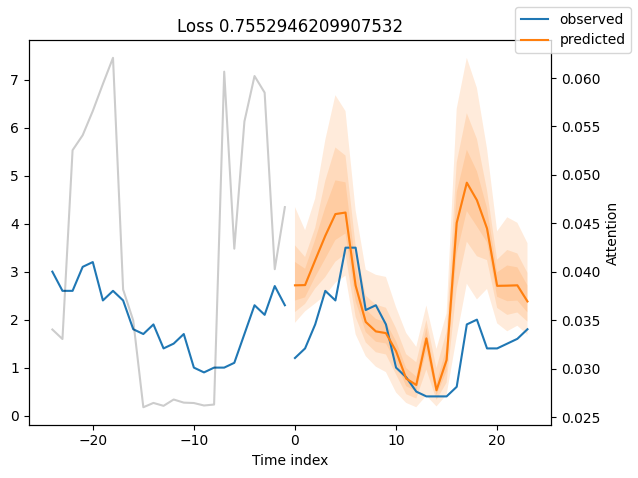

In [45]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x600 with 1 Axes>,
 'decoder_variables': <Figure size 700x325 with 1 Axes>}

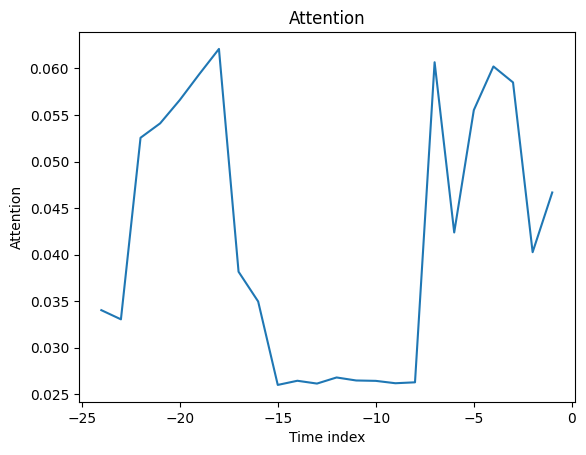

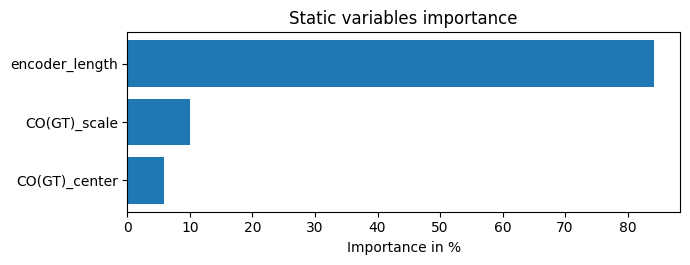

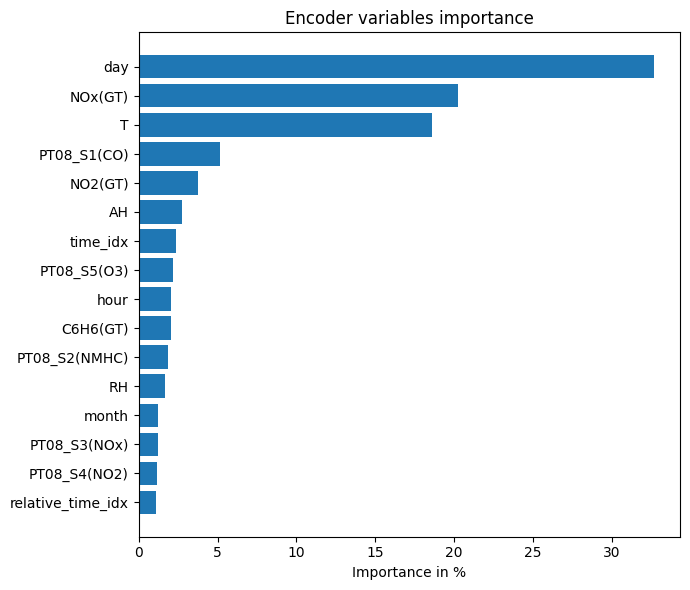

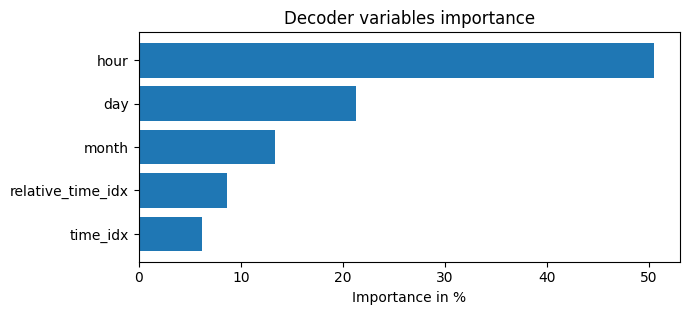

In [46]:
interpretation = tft.interpret_output(raw_predictions.output, reduction="sum")
tft.plot_interpretation(interpretation)

## Evaluation

In [47]:
max_prediction_length = 24
max_encoder_length = 24

test_data['group'] = 0

test = TimeSeriesDataSet(
    test_data,
    time_idx="time_idx",
    target="CO(GT)",  
    group_ids=["group"],  # Single time series
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],  # No static categoricals in the dataset
    static_reals=[],  # No static reals the dataset
    time_varying_known_categoricals=["day", "month", "hour"],  # Time-related features
    time_varying_known_reals=["time_idx"],  # Known reals including time index
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        'PT08_S1(CO)', 'C6H6(GT)', 'PT08_S2(NMHC)', 'NOx(GT)',
       'PT08_S3(NOx)', 'NO2(GT)', 'PT08_S4(NO2)', 'PT08_S5(O3)', 'T', 'RH', 'AH'
    ], 
    target_normalizer=GroupNormalizer(groups=["group"], transformation="softplus"),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,    
    categorical_encoders={
        "day": NaNLabelEncoder(add_nan=True),
        "month": NaNLabelEncoder(add_nan=True),
        "hour": NaNLabelEncoder(add_nan=True)
    }
)

batch_size = 64  
test_dataloader = test.to_dataloader(train=True, batch_size=batch_size, num_workers= 0 )

predictions = tft.predict(test_dataloader, return_x=True, mode = "raw")

INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


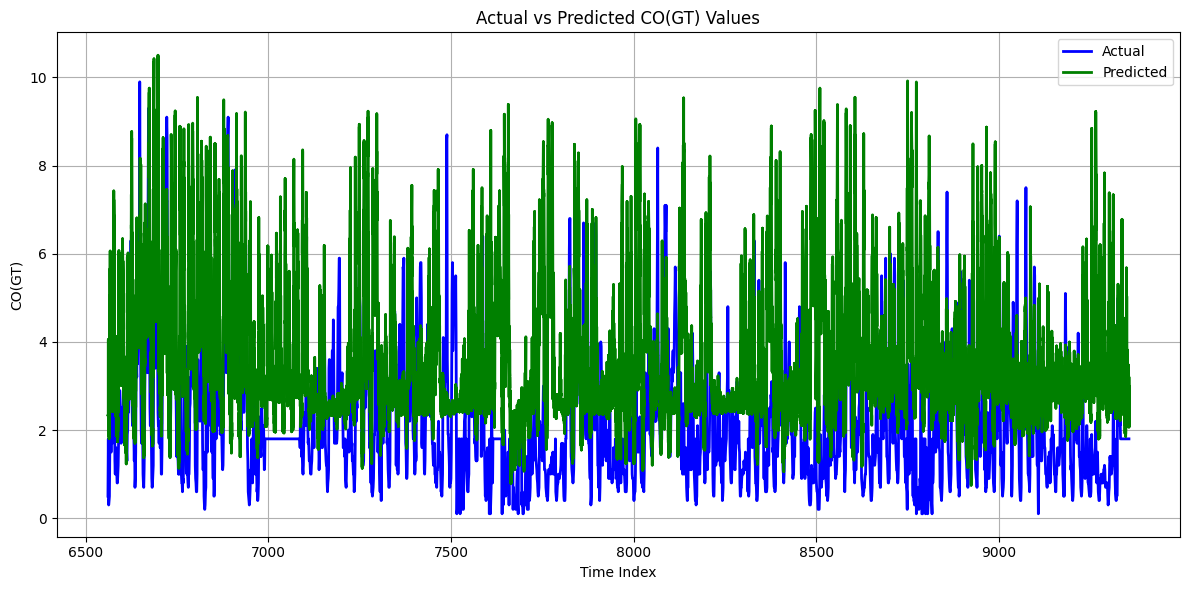

In [51]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract predicted values and time indices
predicted_values = predictions.output[0][:, :, 6].cpu().numpy().flatten()
time_indices = predictions.x['decoder_time_idx'].cpu().numpy().flatten()

# Convert to DataFrame for easier manipulation
predicted_df = pd.DataFrame({
    'time_idx': time_indices,
    'predicted': predicted_values
})

# Ensure you have the correct time_idx format in test_data
test_data_df = test_data[['time_idx', 'CO(GT)']].copy()
test_data_df['time_idx'] = test_data_df['time_idx'].astype(int)

# Merge predicted and actual values based on time_idx
merged_df = pd.merge(test_data_df, predicted_df, on='time_idx', how='inner')

# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))

plt.plot(merged_df['time_idx'], merged_df['CO(GT)'], label='Actual', color='blue', linewidth=2)
plt.plot(merged_df['time_idx'], merged_df['predicted'], label='Predicted', color='green', linewidth=2)

plt.title('Actual vs Predicted CO(GT) Values')
plt.xlabel('Time Index')
plt.ylabel('CO(GT)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [56]:

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

predicted_values = predictions.output[0][:, :, 6].cpu().numpy().flatten()
actual_values = test_data['CO(GT)'].values

# Ensure the length matches for computation
num_predictions = min(len(predicted_values), len(actual_values))
predicted_values = predicted_values[:num_predictions]
actual_values = actual_values[:num_predictions]


mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
#r2 = r2_score(actual_values, predicted_values)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
#print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 1.8868
Mean Squared Error (MSE): 5.9123
Root Mean Squared Error (RMSE): 2.4315
